# Main Notebook for Obesity Data Analysis Project

## Import Necessary Libraries

In [20]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set default visualization style
sns.set_style('whitegrid')
sns.set_palette('deep')



## Load Data

In [21]:
df = pd.read_csv('../data/who_obesity_core_data.csv')
df.shape

/var/folders/n3/pcj4k0m94415fgwnccl63v5r0000gn/T/ipykernel_5954/2764120641.py:1: DtypeWarning: Columns (0,1,2,6,7,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/who_obesity_core_data.csv')


(146334, 28)

## Extracting data for different indicators to separate dataframes and merging them to make it tidy dataframe.

In [ ]:
# Collecting Indicator Codes.
unique_indicators_codes = df['IndicatorCode'].unique()

# Retrieving target Indicator Code.
target_indicator = 'NCD_BMI_30A'

# Dropping the columns that are insignificant in the analysis
indicator_code_df_name_list = []
df = df[~df["Dim1"].isin(["SEX_MLE", "SEX_FMLE", "ALCOHOLTYPE_SA_SPIRITS", "ALCOHOLTYPE_SA_BEER", "ALCOHOLTYPE_SA_WINE", "ALCOHOLTYPE_SA_OTHER_ALCOHOL", "RESIDENCEAREATYPE_URB", "RESIDENCEAREATYPE_RUR"])]
df = df[~df["Dim2"].isin(["AGEGROUP_YEARS30-PLUS"])]
df_without_dim1 = df.drop(columns="Dim1")
df_without_dim = df_without_dim1.drop_duplicates()

# Creating a seperate dataframes for the data associated with each indicator
for code in unique_indicators_codes:
    if target_indicator != code:
        indicators_data_df = df_without_dim[df_without_dim['IndicatorCode'] == code]
        indicators_data_df = indicators_data_df[['SpatialDim', 'TimeDim', 'IndicatorCode', 'IndicatorName', 'NumericValue', 'Value']]
        indicator_code_df_name_list.append(indicators_data_df)
    else:
        target_indicator_data_df = df_without_dim[df_without_dim['IndicatorCode'] == code] 
        target_indicator_data_df = target_indicator_data_df[['SpatialDim', 'TimeDim', 'IndicatorCode', 'IndicatorName', 'NumericValue', 'Value']]


# Map that contains new names for columns to be renamed.
rename_map = {
        "SpatialDim": "CountryCode",
        "TimeDim": "Year"
    }

# Rename columns and droping rows that has null values in all the columns of CountryCode, Year, NumericValue
target_indicator_data_df.rename(columns={k: v for k, v in rename_map.items() if k in target_indicator_data_df.columns}, inplace=True)
target_indicator_data_df.dropna(subset=["CountryCode", "Year", "NumericValue"], inplace=True)

# Saving the target indicator dataset for refernce if needed
# target_indicator_data_df.to_csv("../data/target_indicator_data_df.csv")


# Droping columns that are not required,renaming the column with indicator name and merging the datasets to tidy dataset with key as CountryCode, Year
merged_indicators_data_df = target_indicator_data_df.copy()
merged_indicators_data_df["Year"]  = pd.to_numeric(merged_indicators_data_df["Year"], errors="coerce")
merged_indicators_data_df["NumericValue"] = pd.to_numeric(merged_indicators_data_df["NumericValue"], errors="coerce")

new_name = merged_indicators_data_df["IndicatorCode"].iloc[0]  # get value from the row
merged_indicators_data_df.rename(columns={"NumericValue": new_name}, inplace=True)
merged_indicators_data_df.drop(columns="IndicatorCode", inplace=True)
merged_indicators_data_df.drop(columns="IndicatorName", inplace=True)
merged_indicators_data_df.drop(columns="Value", inplace=True)

counter = 1
for indicator_name_df in indicator_code_df_name_list:
    indicator_name_df.rename(columns={k: v for k, v in rename_map.items() if k in indicator_name_df.columns}, inplace=True)
    indicator_name_df.dropna(subset=["CountryCode", "Year", "Value"], inplace=True)
    indicator_name_df["Year"]  = pd.to_numeric(indicator_name_df["Year"], errors="coerce")
    indicator_name_df["NumericValue"] = pd.to_numeric(indicator_name_df["NumericValue"], errors="coerce")
    if not indicator_name_df.empty:
        new_name = indicator_name_df["IndicatorCode"].iloc[0]  # get value from the row
        if indicator_name_df["NumericValue"].isna().all(): 
            indicator_name_df.rename(columns={"Value": new_name}, inplace=True)
            indicator_name_df.drop(columns="NumericValue", inplace=True)
        else:
            indicator_name_df.rename(columns={"NumericValue": new_name}, inplace=True) 
            indicator_name_df.drop(columns="Value", inplace=True)  
        
        indicator_name_df.drop(columns="IndicatorCode", inplace=True)
        indicator_name_df.drop(columns="IndicatorName", inplace=True)  

    merged_indicators_data_df = pd.merge(merged_indicators_data_df, indicator_name_df, on=["CountryCode", "Year"], how="left") 
    counter += 1

print(merged_indicators_data_df.head(5))

# merged_indicators_data_df.drop(columns=["IndicatorCode","IndicatorName","NumericValue","Value"], inplace=True)   

merged_indicators_data_df.to_csv("../data/merged_indicators_data_df.csv")
print(merged_indicators_data_df.head(2))

  CountryCode    Year  NCD_BMI_30A  NCD_DIABETES_PREVALENCE_CRUDE  \
0         WSM  1991.0    38.792646                       9.220780   
1         BRN  2006.0    18.341002                      10.593857   
2         NLD  1996.0     9.883659                       5.759348   
3         VUT  1996.0    15.233731                       5.790081   
4         FRA  2000.0    11.812260                       6.224879   

   NCD_GLUC_03    NCD_PAA  SI_POV_DAY1  WHS5_512  WHOSIS_000001  \
0          9.1        NaN          NaN       NaN            NaN   
1          7.7  27.775627          NaN       NaN      76.584804   
2          4.9        NaN          NaN       NaN            NaN   
3          7.5        NaN          NaN       NaN            NaN   
4          6.9  38.875439          NaN       NaN      78.911055   

   WSH_SANITATION_BASIC  PHE_HHAIR_PROP_POP_POLLUTING_FUELS  
0                   NaN                                88.9  
1              80.01466                                 0.

## Heat Map

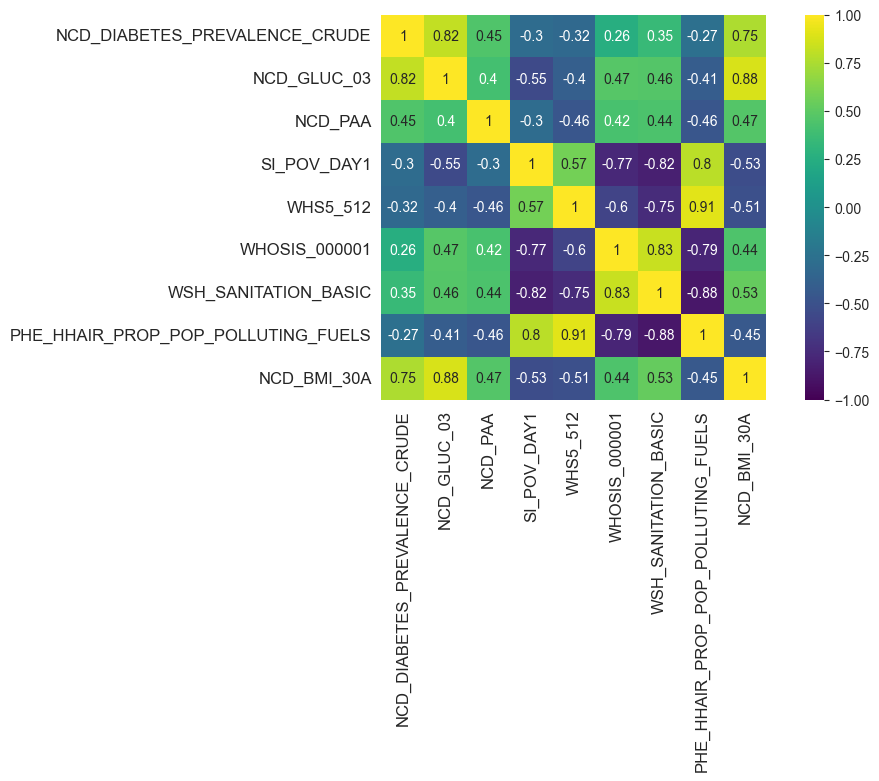

In [19]:
predictors = merged_indicators_data_df.columns[3:]
numerical_predictors = (merged_indicators_data_df[predictors].select_dtypes(include=['number']).columns.to_list())
corr_matrix = merged_indicators_data_df[numerical_predictors + [target_indicator]].corr()
    
plt.figure( figsize=(10, 5))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis")
plt.tick_params(labelsize=12)
plt.show()